<a href="https://colab.research.google.com/github/janinerottmann/Practical-Data-Science/blob/master/4.%20Cars%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 19/20*
# Programming Assignment 4 - Cars Classification

In this programming assignment, you will need to apply your new deep learning knowledge on image classification.

First, you need to import all the necessary packages for this assignment.

In [0]:
from fastai.vision import *
from scipy.io import loadmat # this package is used to load matlab files

## Introduction and Dataset

You are provided with the [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) by [Krause, Jonathan, et al., 2013](https://www.cv-foundation.org//openaccess/content_iccv_workshops_2013/W19/papers/Krause_3D_Object_Representations_2013_ICCV_paper.pdf). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

![Example Car](https://ai.stanford.edu/~jkrause/cars/car4.jpg)

To help you get started, you can use the following code block to download and store the data.

In [0]:
!wget 'http://imagenet.stanford.edu/internal/car196/car_ims.tgz'
!wget 'http://imagenet.stanford.edu/internal/car196/cars_annos.mat'
!tar -xf car_ims.tgz

--2019-12-02 11:49:23--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘car_ims.tgz’

car_ims.tgz         100%[===================>]   1.82G  11.0MB/s    in 1m 49s  

2019-12-02 11:51:12 (17.2 MB/s) - ‘car_ims.tgz’ saved [1956628579/1956628579]

--2019-12-02 11:51:12--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘cars_annos.mat’

cars_annos.mat      100%[===================>] 385.23K  1.35MB/s    in 0.3s    

2019-12-02 11:51:13 (1.35 MB/s) - ‘

In [0]:
# save in drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# change working directory
!pwd
%cd ./drive/My\ Drive

/content
/content/drive/My Drive


All images of this data set are now stored in the `car_ims`directory. List the first 10 image files in this directory.

In [0]:
path_img = 'car_ims'
fnames = get_image_files(path_img)
fnames[:10]

[PosixPath('car_ims/011348.jpg'),
 PosixPath('car_ims/014416.jpg'),
 PosixPath('car_ims/014864.jpg'),
 PosixPath('car_ims/006611.jpg'),
 PosixPath('car_ims/015256.jpg'),
 PosixPath('car_ims/010508.jpg'),
 PosixPath('car_ims/015983.jpg'),
 PosixPath('car_ims/007051.jpg'),
 PosixPath('car_ims/008684.jpg'),
 PosixPath('car_ims/008123.jpg')]

Different data sets are labeled in many different ways. The images of this data set are stored in only one directory with their `id` as file name. The labels are stored in a different file called 'cars_annos.mat'. You can use the following code block to load this file into a DataFrame.

In [0]:
# Create Labels from class names
cars_annos = loadmat('cars_annos.mat')
class_names = cars_annos['class_names']
labels = [c for c in class_names[0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels['class'] = labels.index+1
# Create Data Frame from .mat file
frame = [[i.flat[0] for i in line] for line in cars_annos['annotations'][0]]
columns = [ 'fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class','test']
df = pd.DataFrame(frame, columns=columns)
df = df.merge(labels, on='class')
df.head()

,fname,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,labels
0,car_ims/000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000
1,car_ims/000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000
2,car_ims/000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000
3,car_ims/000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000
4,car_ims/000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000


For now, we only want to work with the train set of the data, i.e, the files where the column `test` is 0. Filter the DataFrame `df` accordingly and save it as `df_train`. 

In [0]:
df_train = df[df['test'] == 0]
df_train.head()

,fname,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,labels
0,car_ims/000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000
1,car_ims/000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000
2,car_ims/000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000
3,car_ims/000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000
4,car_ims/000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000


## Creating the DataBunch

Fast.ai expects the data to be loaded as a Data Bunch. Use the [data block API](https://docs.fast.ai/data_block.html) to 
1. load the data using `df_train` ([from_df](https://docs.fast.ai/vision.data.html#ImageList.from_df))
2. split the images randomly into 85% train and 15% test set ([docs](https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set), use seed = 0)
3. label the inputs using the column 'labels' in the DataFrame

Note: If a function requires a `path` argument, set `path=""`.

In [0]:
data = ImageDataBunch.from_df(path = "",
                             df = df_train,
                             valid_pct= 0.15, 
                             seed=None,
                             label_col="labels",
                             size=224,
                             bs=64).normalize(imagenet_stats)

4. apply the [default fast.ai transforms](https://docs.fast.ai/vision.transform.html#get_transforms) and crop the images to a size of 224x224 pixel.
5. create a DataBunch with a batch size of 64
6. normalize the data to the imagenet statistics

In [0]:
# combined step 1-3 and 4-6 above

Now, use the DataBunch to display three rows of random pictures from a batch.

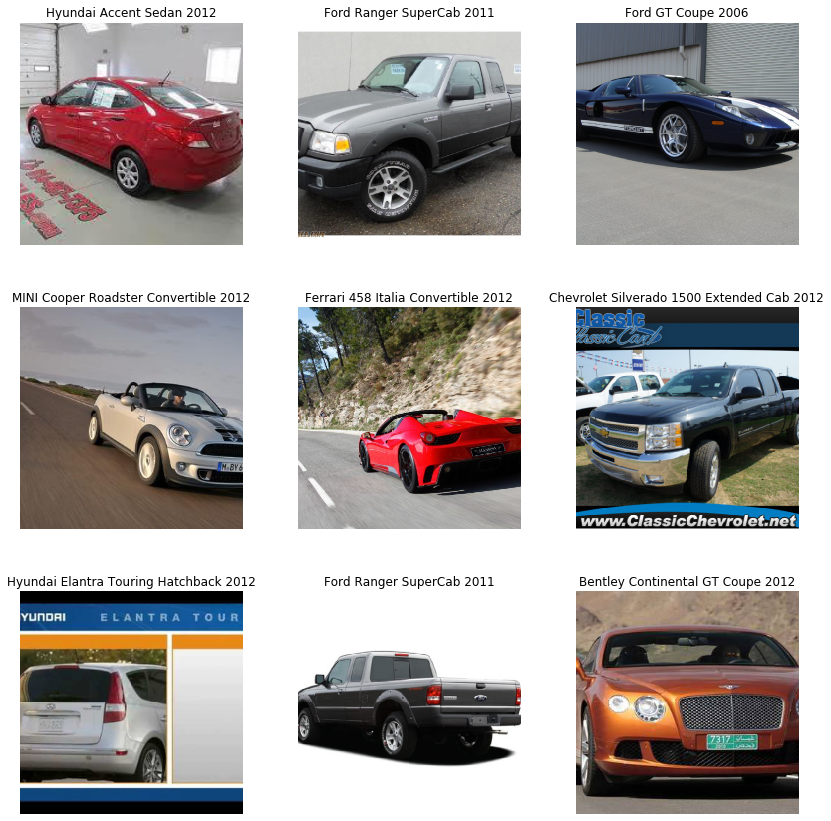

In [0]:
data.show_batch(3)

The data set description states that there are 196 vehicle classes in the data set. Verify this statement using the data stored in the DataBunch.

In [0]:
len(data.classes)

196

## Train the Model

Once the data is ready you can start training a model. Use the `cnn_learner` to create a model with 
- a Resnet34 architecture
- the metrics *accuracy* and [*top-5 accuracy*](https://docs.fast.ai/metrics.html#top_k_accuracy)

Note: You will need to import the metrics from the module `fastai.metrics`


In [0]:
from fastai.metrics import *
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, top_k_accuracy])

Finally, you can train the model. Apply the concepts from the lecture, i.e., 
- finding the learning rate
- training the last layers
- unfreezing the model
- train all layers (learning rate rule of thumb!)

Always provide an explanation **why** you chose the number of epochs and the learning rate.

Save the model after each training 
```
learn.save('stage-x')
``` 
so that you can reload the model 
``` 
learn = learn.load('stage-x')
``` 
if something goes wrong. If you load a model with *freezed* layers, you need to *unfreeze* the layers again.

In [0]:
# find learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 4.79E-03


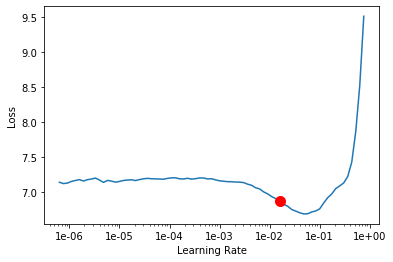

In [0]:
# plot learning rate
learn.recorder.plot(suggestion=True)

In [0]:
# find min numerical gradient
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.01584893192461114

In [0]:
# fit model
learn.fit_one_cycle(5, max_lr=slice(min_grad_lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.945385,3.531865,0.223587,0.496314,03:23
1,3.523545,2.584628,0.355446,0.671581,03:23
2,2.268199,2.012221,0.486486,0.767404,03:27
3,1.370787,1.787050,0.526618,0.819001,03:36
4,0.825774,1.707985,0.553645,0.828829,03:38


Interpretation of the first training:
- accuracy of 55% is hardly better than guessing
- interesstingly the top-5-accuracy is pretty high. My guess is that there are a few car models that the model has difficulties to differentiate. Other than that it does a pretty good job classifying different models.
- perhaps this misclassification gets better with more epochs

In [0]:
# save
learn.save('stage-1')

In [0]:
# unfreeze
learn.unfreeze()

In [0]:
# and start training again
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Apart from choosing a higher number of epochs I applied the rule of thumb. 
Thereby I passed the max learning parameter:
- the new min numerical gradient 
- and the 10th of the old min numerical gradient

Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.75E-07
7.585775750291837e-07


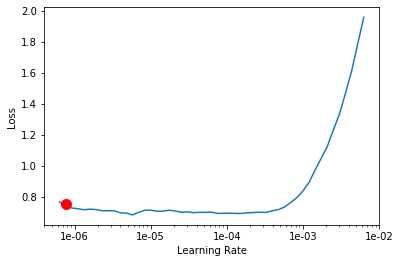

In [0]:
# new min numerical gradient to pass to slice
learn.recorder.plot(suggestion=True)
min_grad_lr_new = learn.recorder.min_grad_lr

In [0]:
# 10th of old min numerical gradient to pass to slice
min_grad_lr_old = min_grad_lr * 0.1
min_grad_lr_old

0.01584893192461114

In [0]:
learn.fit_one_cycle(10, max_lr=slice(min_grad_lr_new,min_grad_lr_old))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.681348,1.674931,0.556921,0.828829,03:41
1,0.613839,1.629198,0.576577,0.838657,03:43
2,0.481353,1.616742,0.580672,0.846028,03:45
3,0.339565,1.589157,0.584767,0.854218,03:45
4,0.209334,1.513440,0.602785,0.864046,03:45
5,0.130555,1.488147,0.620803,0.871417,03:44
6,0.086927,1.487749,0.615889,0.875512,03:45
7,0.070558,1.478626,0.627355,0.874693,03:44
8,0.057567,1.468222,0.627355,0.880426,03:43
9,0.047345,1.472055,0.620803,0.876331,03:46


What I have learned:
- the model does a better job right from the beginning 
- it keeps getting better within the first 6 iterations
- after that the loss on the training set significantly decreases and the accuracy hardly gets any better (overfitting)

Therefore I reloaded stage 1 of the training process and trained the model once again with 6 epochs

In [0]:
# reload stage 1 and train model for 6 epochs
learn = learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(min_grad_lr_new,min_grad_lr_old))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.662318,1.662374,0.556102,0.834562,03:39
1,0.601485,1.595873,0.579853,0.844390,03:20
2,0.404281,1.544467,0.592957,0.855037,03:31
3,0.247470,1.483153,0.622441,0.864046,03:33
4,0.151764,1.457881,0.621622,0.866503,03:34
5,0.114435,1.458078,0.615070,0.867322,03:35


## Result Interpretation






Explain the difference betweeen the metrics *accuracy* and *top_5_accuracy*. Why can it be useful to report both metrics?

Accuracy measures the precision of all classifications whereas the top-k-accuracy measures whether the guess would have been correct within the first k guesses. 

Example:
If you were to classify 10 different kinds of fruits and the model does good in 8 classes but has trouble keeping pears and quits appart then the accuracy might be pretty low whereas the top-2-accuracy would be nearly 100%.
This means that the model is almost perfect apart from differentiating two types of fruits which probably most people couldn't tell apart eighter but one doesn't realize it by only looking at the accuracy metric.

[Selvaraju, Ramprasaath R., et al. (2017)](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) propose a technique for producing ‘visual explanations’ for decisions from a large class of Convolutional Neural Network (CNN)-based models, making them more transparent. 

- Apply the proposed technique to interpret the output of the model. The [ClassificationInterpretation](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) should alleviate the solution of this task. 
- Why do you think the model misclassified these images?

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

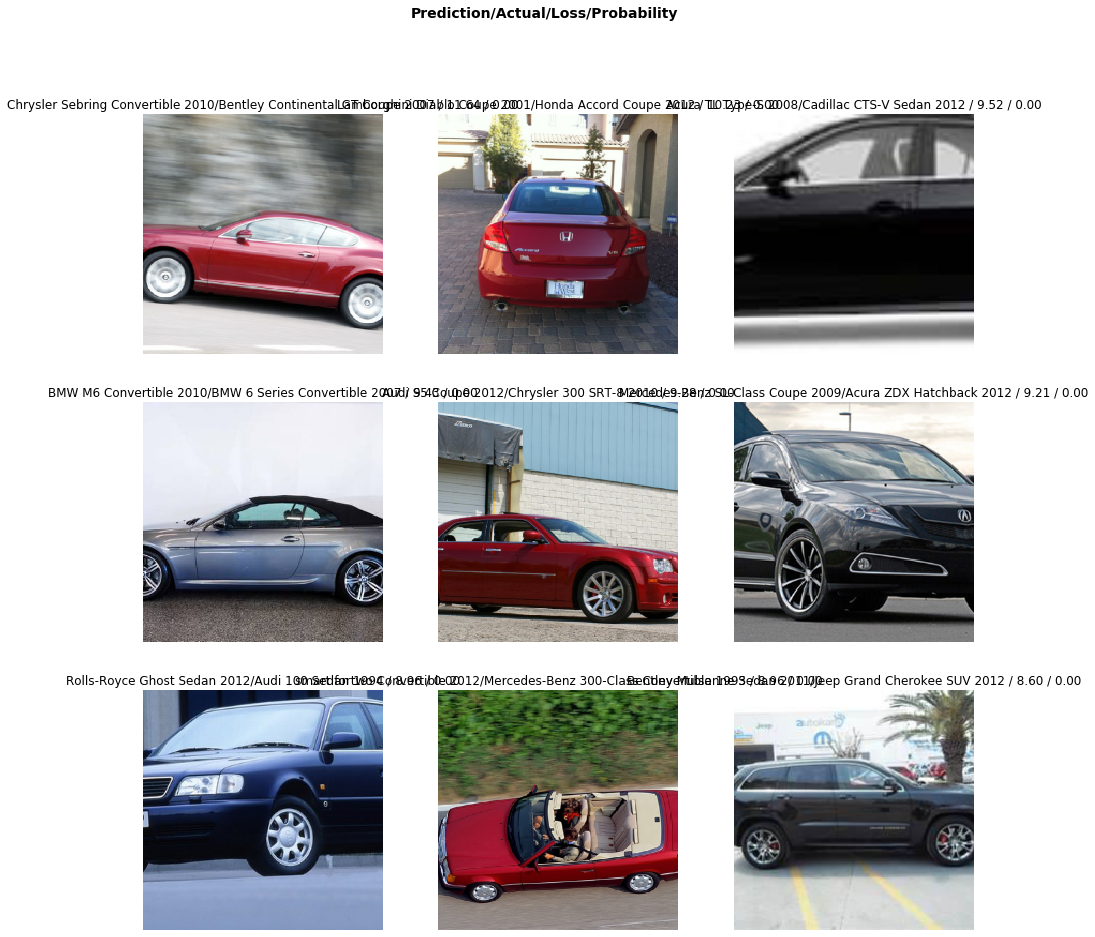

In [0]:
# visual explanation
interp.plot_top_losses(9, figsize=(15,15))

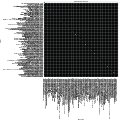

In [0]:
# confusion matrix
# there are too may classes to map in a single confusion matrix (even with dpi = 100)
interp.plot_confusion_matrix(figsize=(12,12), dpi=10)

In [0]:
# ordered list
interp.most_confused(min_val=2)

[('Chevrolet Express Van 2007', 'Chevrolet Express Cargo Van 2007', 5),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 5),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  5),
 ('Audi S5 Convertible 2012', 'Audi RS 4 Convertible 2008', 4),
 ('Acura TL Sedan 2012', 'Acura RL Sedan 2012', 3),
 ('Audi S4 Sedan 2012', 'Audi S6 Sedan 2011', 3),
 ('BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 3),
 ('BMW 1 Series Coupe 2012', 'BMW M3 Coupe 2012', 3),
 ('BMW 6 Series Convertible 2007', 'BMW M6 Convertible 2010', 3),
 ('Chevrolet Malibu Sedan 2007', 'Chevrolet Impala Sedan 2007', 3),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  3),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3),
 ('Dodge Sprinter Cargo Van 2009', 'Mercedes-Benz Sprinter Van 2012', 3),
 ('GMC Savana Van 2012', 'Chevrolet Express Van 2007', 3),
 ('Hyundai Azera Sedan 2012', 'Hyundai Sonat

Interpretation:

Most images were *'misclassified'* due to extremely detailed model names. 
A Chevrolet **Express** Van 2007 hardly looks any different than a Chevrolet **Express Cargo** Van 2007.
Still it's a different car model and therefore misclassified.

This explaines why the accuracy was significantly lower than the top-5-accuracy. The model would have classified it almost correctly but only with the second start.
